In [52]:
import os, h5py
import pandas as pd
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import pyproj
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
## Create a dataframe for collecting all data
df = pd.DataFrame([], columns=["date", "lats", "lons", "night_flag", "max_canopy_height_m","data_quality_flag"])

### Extract data for each hdf5 file in the folder from Oct 2018 to Feb 2021

os.chdir('/home/shashank/Downloads/icesat2/icesat2_data')

for filename in sorted(glob.glob("*.h5")):
     print("working on %s" %filename)     
    
     #### Extract date from file name    
     date_str = filename.split("_")[1][0:8]
     date_obj  = datetime.strptime(date_str,'%Y%m%d')
     date = datetime.strftime(date_obj, '%d %B,%Y')
     
     ### Import the hdf file 
     f = h5py.File(filename, 'r')

     ### Extract data for all 3 strong beams
     beam_numbers = ['/gt1r', '/gt2r', '/gt3r']

     for beam in beam_numbers: 
  
         ### Extract required parameters from hdf
         lons = pd.DataFrame(f[beam + '/land_segments/longitude'][:])
         lats = pd.DataFrame(f[beam + '/land_segments/latitude'][:])
         night_flag = pd.DataFrame(f[beam + '/land_segments/night_flag'][:]) ## day=0, night=1 
         h_canopy = pd.DataFrame(f[beam + '/land_segments/canopy/h_canopy'][:]) ## 98 ptile of all canopy heights
         ## Use quality flag information to filter data    
         ## Create a variable which counts the number of times '1' appears in the canopy flag
         ## -1: no data within geosegment available for analysis; 0: indicates no canopy photons within geosegment; 1: indicates canopy photons within geosegment
         ## For example, a 100 m ATL08 segment might have the following subset_can_flags: {-1 -1 -1 1 1} which would translate that no photons (canopy orground) were available for processing in the first three geosegments.
         canopy_flag = pd.DataFrame(f[beam + '/land_segments/canopy/subset_can_flag'][:]) 
         counter = pd.DataFrame([], index=np.arange(0, len(canopy_flag)), columns=["counter"])
         for i in range(0, len(counter)):
            count=0
            segment = canopy_flag.iloc[i,:]
            for j in range(0, 5):
                if segment[j] == 1:
                  count+=1
            counter["counter"][i] = count         
        
         ### Create a column of dates 
         dates_arr = []
         for i in range(0, len(h_canopy)):
            dates_arr.append(date)
            dates_df = pd.DataFrame(dates_arr, columns=["date"])
         
         ### Combine all the extracted parameters into a dataframe
         canopy_height_data = pd.concat([dates_df, lats, lons, night_flag, h_canopy, counter], axis=1, ignore_index=True)
         canopy_height_data.columns = df.columns
            
         ### Drop pixels with no-data value 3.4028235e+38 and drop all pixels below 18 degree latitude
         canopy_height_data = canopy_height_data[canopy_height_data["max_canopy_height_m"] < 1e+38] 
        
         ### Consider only pixels within the Cabo Rojo region
         canopy_height_data = canopy_height_data[canopy_height_data["lats"]>18]
         canopy_height_data = canopy_height_data[(canopy_height_data["lons"] > -67.20) &
                                                 (canopy_height_data["lons"] < -66.78)]
            
         ### Extract only day/night time data
         canopy_height_data = canopy_height_data[canopy_height_data["night_flag"]==0]
            
         ### Extract data with data quality counter
         ## Most points have counter value 5. So, choosing only those. 
         canopy_height_data = canopy_height_data[canopy_height_data["data_quality_flag"]==5]
            
         ### Append canopy height data at the bottom of df
         df = df.append(canopy_height_data, ignore_index=True)

In [21]:
print(df.head())
print(df.shape)

              date       lats       lons night_flag  max_canopy_height_m  \
0  28 October,2018  18.000145 -66.838699          0             8.357735   
1  28 October,2018  18.001045 -66.838791          0             7.397915   
2  28 October,2018  18.001947 -66.838890          0             9.678333   
3  28 October,2018  18.003750 -66.839088          0            13.336039   
4  28 October,2018  18.047035 -66.843521          0            16.347973   

  data_quality_flag  
0                 5  
1                 5  
2                 5  
3                 5  
4                 5  
(7247, 6)


In [ ]:
### Convert the lat lons to UTM projection

proj_wgs84 = pyproj.Proj(init='epsg:4326')
proj_utm = pyproj.Proj(init='epsg:32620')

utmx = pd.DataFrame([], index=np.arange(0, len(df)), columns=["Northing"])
utmy = pd.DataFrame([], index=np.arange(0, len(df)), columns=["Easting"])

for i in range(0, len(df)):
   print(i)
   x, y = pyproj.transform(proj_wgs84, proj_utm, df["lons"][i], df["lats"][i])
   utmx["Northing"][i] = x
   utmy["Easting"][i] = y

df = pd.concat([df, utmx, utmy], axis=1, ignore_index=True)
df.columns = ["date", "lats", "lons", "night_flag", "max_canopy_height_m","data_quality_flag", "Northing", "Easting"]
df.to_csv("icesat2_max_canopy_height_all_hdfs_day.csv", sep=",", header=True, index=False, 
          columns=["Northing", "Easting","max_canopy_height_m","night_flag"])

In [ ]:
### GRASS GIS ###
### Imported the GliHt tiff file in UTM projection : Location glight and Mapset PERMANENT on linux laptop
### Created a raster map for ICESat2 max canopy heights in the same projection.
### Extracted the ICESat2 height for all locations where Gliht data is available

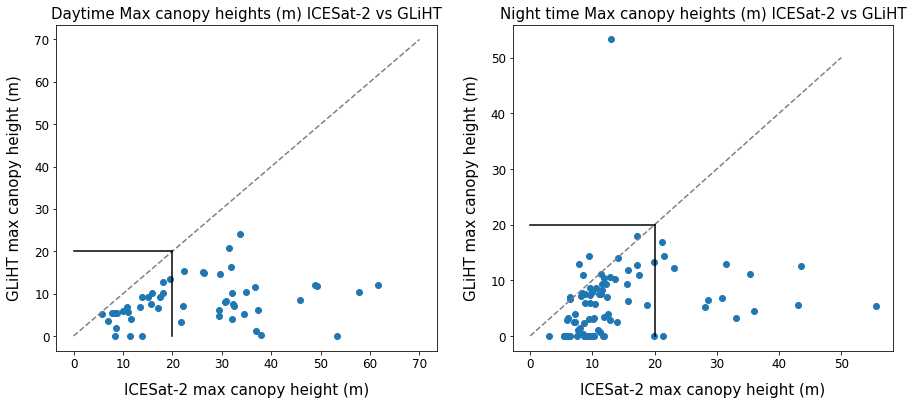

In [84]:
### Compare the GLiHt max canopy heights with ICESat2 

day_data = pd.read_csv("r.stats_compare_icesat2_day_gliht_max_canopy", header=None, sep=" ", 
                        names=["icesat2","gliht"])
night_data = pd.read_csv("r.stats_compare_icesat2_night_gliht_max_canopy", header=None, sep=" ",
                        names=["icesat2","gliht"])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

## Plot Daytime
ax1.plot(day_data["icesat2"],day_data["gliht"],"o")
ax1.set_title("Daytime Max canopy heights (m) ICESat-2 vs GLiHT", fontsize=15)
ax1.set_xlabel("ICESat-2 max canopy height (m)", fontsize=15, labelpad=12)
ax1.set_ylabel("GLiHT max canopy height (m)", fontsize=15, labelpad=12)
ax1.set_xticks(np.arange(0,80,10))
ax1.set_yticks(np.arange(0,80,10))
ax1.set_xticklabels(np.arange(0,80,10), fontsize=12)
ax1.set_yticklabels(np.arange(0,80,10), fontsize=12)
ax1.plot(np.arange(0,80,10), np.arange(0,80,10), '--', c='grey')
ax1.plot([20,20], [0,20], c='black')
ax1.plot([0,20], [20,20], c='black')

## Plot Nighttime
ax2.plot(night_data["icesat2"],night_data["gliht"],"o")
ax2.set_title("Night time Max canopy heights (m) ICESat-2 vs GLiHT", fontsize=15)
ax2.set_xlabel("ICESat-2 max canopy height (m)", fontsize=15, labelpad=12)
ax2.set_ylabel("GLiHT max canopy height (m)", fontsize=15, labelpad=12)
ax2.set_xticks(np.arange(0,60,10))
ax2.set_yticks(np.arange(0,60,10))
ax2.set_xticklabels(np.arange(0,60,10), fontsize=12)
ax2.set_yticklabels(np.arange(0,60,10), fontsize=12)
ax2.plot(np.arange(0,60,10), np.arange(0,60,10), '--', c='grey')
ax2.plot([20,20], [0,20], c='black')
ax2.plot([0,20], [20,20], c='black')

plt.show()

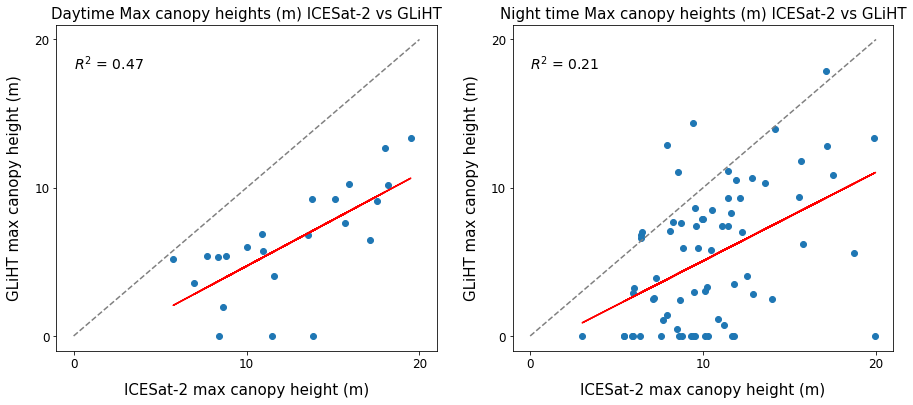

In [85]:
### Compare the GLiHt max canopy heights with ICESat2 

day_data = pd.read_csv("r.stats_compare_icesat2_day_gliht_max_canopy", header=None, sep=" ", 
                        names=["icesat2","gliht"])
night_data = pd.read_csv("r.stats_compare_icesat2_night_gliht_max_canopy", header=None, sep=" ",
                        names=["icesat2","gliht"])

## Remove outliers from data
day_data = day_data[(day_data["icesat2"] < 20) & (day_data["gliht"] < 20)]
night_data = night_data[(night_data["icesat2"] < 20) & (night_data["gliht"] < 20)]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

## Plot Daytime
ax1.plot(day_data["icesat2"],day_data["gliht"],"o")
ax1.set_title("Daytime Max canopy heights (m) ICESat-2 vs GLiHT", fontsize=15)
ax1.set_xlabel("ICESat-2 max canopy height (m)", fontsize=15, labelpad=12)
ax1.set_ylabel("GLiHT max canopy height (m)", fontsize=15, labelpad=12)
ax1.set_xticks(np.arange(0,30,10))
ax1.set_yticks(np.arange(0,30,10))
ax1.set_xticklabels(np.arange(0,30,10), fontsize=12)
ax1.set_yticklabels(np.arange(0,30,10), fontsize=12)
ax1.plot(np.arange(0,30,10), np.arange(0,30,10), '--', c='grey')

# Linear regression
reg = LinearRegression().fit(np.array(day_data["icesat2"]).reshape(-1, 1), np.array(day_data["gliht"]).reshape(-1, 1))
m = reg.coef_[0][0]
c = reg.intercept_
ax1.plot(day_data["icesat2"], m*day_data["icesat2"] + c, c='red')
r2 = str(round(reg.score(np.array(day_data["icesat2"]).reshape(-1, 1), np.array(day_data["gliht"]).reshape(-1, 1)), 2))
ax1.text(0,18,"$R^2$ = %s" %r2, fontsize=14)
#ax1.text(0,16,"slope = %s" %str(round(m, 2)), fontsize=14)


## Plot Nighttime
ax2.plot(night_data["icesat2"],night_data["gliht"],"o")
ax2.set_title("Night time Max canopy heights (m) ICESat-2 vs GLiHT", fontsize=15)
ax2.set_xlabel("ICESat-2 max canopy height (m)", fontsize=15, labelpad=12)
ax2.set_ylabel("GLiHT max canopy height (m)", fontsize=15, labelpad=12)
ax2.set_xticks(np.arange(0,30,10))
ax2.set_yticks(np.arange(0,30,10))
ax2.set_xticklabels(np.arange(0,30,10), fontsize=12)
ax2.set_yticklabels(np.arange(0,30,10), fontsize=12)
ax2.plot(np.arange(0,30,10), np.arange(0,30,10), '--', c='grey')

# Linear regression
reg = LinearRegression().fit(np.array(night_data["icesat2"]).reshape(-1, 1), np.array(night_data["gliht"]).reshape(-1, 1))
m = reg.coef_[0][0]
c = reg.intercept_
ax2.plot(night_data["icesat2"], m*night_data["icesat2"] + c, c='red')
r2 = str(round(reg.score(np.array(night_data["icesat2"]).reshape(-1, 1), np.array(night_data["gliht"]).reshape(-1, 1)), 2))
ax2.text(0,18,"$R^2$ = %s" %r2, fontsize=14)
#ax2.text(0,16,"slope = %s" %str(round(m, 2)), fontsize=14)

plt.show()

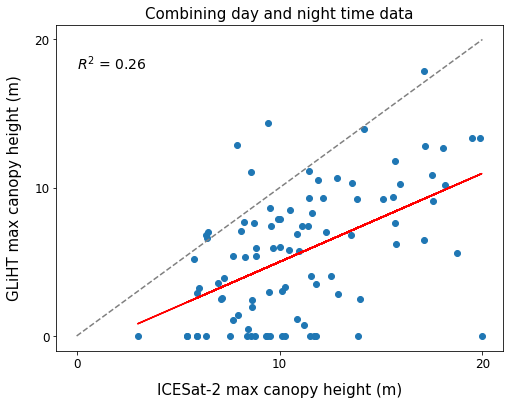

In [89]:
day_data = pd.read_csv("r.stats_compare_icesat2_day_gliht_max_canopy", header=None, sep=" ", 
                        names=["icesat2","gliht"])
night_data = pd.read_csv("r.stats_compare_icesat2_night_gliht_max_canopy", header=None, sep=" ",
                        names=["icesat2","gliht"])

## Remove outliers from data
day_data = day_data[(day_data["icesat2"] < 20) & (day_data["gliht"] < 20)]
night_data = night_data[(night_data["icesat2"] < 20) & (night_data["gliht"] < 20)]

### Combine day and night time data
combined_data = day_data.append(night_data, ignore_index=True)
combined_data.columns=["icesat2","gliht"]

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(combined_data["icesat2"],combined_data["gliht"],"o")
ax.set_title("Combining day and night time data", fontsize=15)
ax.set_xlabel("ICESat-2 max canopy height (m)", fontsize=15, labelpad=12)
ax.set_ylabel("GLiHT max canopy height (m)", fontsize=15, labelpad=12)
ax.set_xticks(np.arange(0,30,10))
ax.set_yticks(np.arange(0,30,10))
ax.set_xticklabels(np.arange(0,30,10), fontsize=12)
ax.set_yticklabels(np.arange(0,30,10), fontsize=12)
ax.plot(np.arange(0,30,10), np.arange(0,30,10), '--', c='grey')

# Linear regression
reg = LinearRegression().fit(np.array(combined_data["icesat2"]).reshape(-1, 1), np.array(combined_data["gliht"]).reshape(-1, 1))
m = reg.coef_[0][0]
c = reg.intercept_
ax.plot(combined_data["icesat2"], m*combined_data["icesat2"] + c, c='red')
r2 = str(round(reg.score(np.array(combined_data["icesat2"]).reshape(-1, 1), np.array(combined_data["gliht"]).reshape(-1, 1)), 2))
ax.text(0,18,"$R^2$ = %s" %r2, fontsize=14)
#ax.text(0,16,"slope = %s" %str(round(m, 2)), fontsize=14)

plt.show()